In [1]:
import numpy as np
import os
import datetime as datetime
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input,Dropout, LSTM, multiply,Bidirectional,Permute,Reshape,Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.models import Model
# convert an array of values into a dataset matrix
from google.colab import drive
drive.mount('/drive')
import keras.backend as K
from numpy import array , hstack
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

Mounted at /drive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import pandas as pd
import glob
from pathlib import Path

path = "/drive/My Drive/fastStorage/files/" # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))

li = []
j=0
for filename in all_files:
  j=j+1
  print(j)
  df = pd.read_csv(filename,sep=';\t')
  df['resource_id']=int(Path(filename).stem)
  li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)


1


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [3]:
frame["Memory usage [%]"]=frame["Memory usage [KB]"]*100/frame["Memory capacity provisioned [KB]"]

In [4]:
# df.info() ["CPU usage [%]","Memory usage [KB]","Disk read throughput [KB/s]","Disk write throughput [KB/s]","Network received throughput [KB/s]","Network transmitted throughput [KB/s]"]

In [5]:
lst = [322,324,329,331,332,338,339,340,341,342,343,344,356,357,361,367,125,135,242,245,246,183,184,185,1299,1240,186,187]
frame = frame.loc[frame['resource_id'].isin(lst)]

In [10]:
from keras.layers import *
class attention(Layer):
    
    def __init__(self, return_sequences=True,**kwargs):
        self.return_sequences = return_sequences
        super(attention,self).__init__()

    

    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'return_sequences': self.return_sequences 
      })
      return config
      
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)


import tensorflow as tf



In [11]:

def prepareDF(col,dataframeSet):
  df = dataframeSet[dataframeSet['resource_id'] ==col] 
  df = df.groupby([df.index]).first()
  df1 = pd.date_range(
  start=df.index.min(), end=df.index.max(),freq="30T").difference(df.index)
  #print('missing values',len(df1))
  for i in df1:
    df.loc[i] = np.nan
    #df = df.sort_index()

  # if(len(df[(df.PCT.isnull()) & (df.PCT.shift().isnull())& (df.PCT.shift().shift().isnull())])!=0):
  #   print('corrupted df',col,' length ',len(df[(df.PCT.isnull()) & (df.PCT.shift().isnull())& (df.PCT.shift().shift().isnull())]))
  #   #df =pd.DataFrame()
    
  # else:
    #print('not corrupted df',col,)
  df = df.sort_index()
  df = df.fillna(method='ffill')
  df = df.fillna(method='bfill')
  df = df.groupby(df.index).last()
  return df
  
def create_dataset(data_seq, n_steps_in, n_steps_out):


  X, y = list(), list()
  colList = data_seq.resource_id.unique();
  for col in colList:
    cluster_train_data = data_seq[data_seq['resource_id'] ==col] 
    sequences = cluster_train_data.values
    for i in range(len(sequences)):
      # find the end of this pattern
      end_ix = i + n_steps_in
      out_end_ix = end_ix + n_steps_out-1
      # check if we are beyond the dataset
      if out_end_ix > len(sequences):
        break
      # gather input and output parts of the pattern
      seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1:out_end_ix, 0]
      X.append(seq_x)
      y.append(seq_y)
  return array(X), array(y)


In [12]:
from datetime import datetime
frame['Datetime'] = pd.to_datetime(frame['Timestamp [ms]'], 
                                  unit='s')
frame = frame.drop(['Timestamp [ms]'], axis = 1)
frame=frame.set_index('Datetime')

KeyError: ignored

In [13]:
#fix random seed for reproducibility
np.random.seed(7)
# load the dataset
dfs = []

#dataframeSet = pd.read_csv('/drive/My Drive/massive.csv',index_col='start_interval',parse_dates=True)
dataframeSet = frame[[ 'CPU usage [%]','resource_id']]
dataframeSet['id']=dataframeSet['resource_id']
dataframeSet = dataframeSet[dataframeSet['resource_id'].notna()]
i=0
for col in dataframeSet.resource_id.unique():
  if(i==100):
    break;
  dfs.append(prepareDF(col,dataframeSet))
  i=i+1
  print("cluster-id",i)
dataframe = pd.concat(dfs, axis=0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


cluster-id 1
cluster-id 2
cluster-id 3
cluster-id 4
cluster-id 5
cluster-id 6
cluster-id 7
cluster-id 8
cluster-id 9
cluster-id 10
cluster-id 11
cluster-id 12
cluster-id 13
cluster-id 14
cluster-id 15
cluster-id 16
cluster-id 17
cluster-id 18
cluster-id 19
cluster-id 20
cluster-id 21
cluster-id 22
cluster-id 23
cluster-id 24
cluster-id 25
cluster-id 26
cluster-id 27


In [14]:
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)
dataframe[:]=dataset
dataframe['resource_id'][:]=dataframe['resource_id'].apply(lambda x:float(format( x,".6f")))


In [25]:
import datetime
train = dataframe[dataframe.index<datetime.datetime(2013, 9, 8)] 
test = dataframe[dataframe.index>datetime.datetime(2013, 9, 8)]
#train = train[train['database_id'] ==col]
look_back = 48
out_num=192
trainX, trainY = create_dataset(train, look_back,out_num)
print ("X.shape" , trainX.shape) 
print ("y.shape" , trainY.shape)

batch_size = 1
#time_steps = 193
features = 3
stateful = False
single = False
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1],features))
trainY = trainY.reshape((trainY.shape[0], trainY.shape[1]))
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

custom_early_stopping = EarlyStopping(
    monitor='loss', 
    patience=20, 
    min_delta=0.001, 
    mode='max'
)

# input = Input(batch_input_shape=(batch_size,look_back,features), name='input', dtype='float32')
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=None, decay=0.0)
# model = Sequential()
# model.add(input)
# model.add((LSTM(24, return_sequences=True,return_state=False,stateful=stateful)))
# model.add(Dropout(0.10))
# model.add((LSTM(12, return_sequences=True,return_state=False,stateful=stateful)))
# model.add(Dropout(0.10))
# model.add((LSTM(8, return_sequences=True,return_state=False,stateful=stateful)))
# model.add(Dropout(0.10))
# model.add(attention(return_sequences=False))
# model.add(Bidirectional(LSTM(16, return_sequences=True,return_state=False,stateful=stateful)))
#model.add(Dropout(0.25))
# model.add(Bidirectional(LSTM(32, return_sequences=False,return_state=False,stateful=stateful)))
#model.add(Dense(units=out_num))#,activation='linear',kernel_constraint=tf.keras.constraints.NonNeg()


#model.compile(optimizer= optimizer, loss='mean_squared_error', metrics=[rmse],run_eagerly=True)
# model.compile(metrics=[rmse],run_eagerly=True,loss='mean_squared_error', optimizer=optimizer)
# history = model.fit(trainX, trainY, batch_size=5000, epochs=60, verbose=2, validation_split=0.3,callbacks=[custom_early_stopping])


input = Input(batch_input_shape=(batch_size,look_back,features), name='input', dtype='float32')
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model = Sequential()
model.add(input)
model.add(Bidirectional(LSTM(20, return_sequences=True,return_state=False,stateful=stateful)))
model.add(Bidirectional(LSTM(50, return_sequences=False,return_state=False,stateful=stateful)))
model.add(keras.layers.RepeatVector(192))
model.add(attention(return_sequences=True)) # receive 3D and output 2D

# model.add(Bidirectional(LSTM(16, return_sequences=True,return_state=False,stateful=stateful)))
# model.add(Bidirectional(LSTM(8, return_sequences=True,return_state=False,stateful=stateful)))
# model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(50, return_sequences=True,return_state=False,stateful=stateful)))
model.add(Bidirectional(LSTM(20, return_sequences=False,return_state=False,stateful=stateful)))
model.add(Dense(units=192))
model.compile(optimizer= optimizer, loss='mean_squared_error', metrics=[rmse],run_eagerly=True)

#enco_deco.compile(metrics=[rmse],run_eagerly=True,loss='mean_squared_error', optimizer=optimizer)
history = model.fit(trainX, trainY, batch_size=5000, epochs=60, verbose=2, validation_split=0.3,callbacks=[custom_early_stopping])

X.shape (228485, 48, 3)
y.shape (228485, 192)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/60
32/32 - 16s - loss: 0.1272 - rmse: 0.2648 - val_loss: 0.0070 - val_rmse: 0.0702 - 16s/epoch - 491ms/step
Epoch 2/60
32/32 - 15s - loss: 0.0723 - rmse: 0.1897 - val_loss: 0.0073 - val_rmse: 0.0632 - 15s/epoch - 477ms/step
Epoch 3/60
32/32 - 15s - loss: 0.0770 - rmse: 0.1949 - val_loss: 0.0099 - val_rmse: 0.0798 - 15s/epoch - 477ms/step
Epoch 4/60
32/32 - 15s - loss: 0.0704 - rmse: 0.1875 - val_loss: 0.0069 - val_rmse: 0.0713 - 15s/epoch - 477ms/step
Epoch 5/60
32/32 - 15s - loss: 0.0718 - rmse: 0.1908 - val_loss: 0.0081 - val_rmse: 0.0675 - 15s/epoch - 478ms/step
Epoch 6/60
32/32 - 15s - loss: 0.0702 - rmse: 0.1884 - val_loss: 0.0087 - val_rmse: 0.0779 - 15s/epoch - 476ms/step
Epoch 7/60
32/32 - 15s - loss: 0.0699 - rmse: 0.1882 - val_loss: 0.0072 - val_rmse: 0.0725 - 15s/epoch - 477ms/step
Epoch 8/60
32/32 - 15s - loss: 0.0689 - rmse: 0.1872 - val_loss: 0.0085 - val_rmse: 0.0795 - 15s/epoch - 477ms/step
Epoch 9/60
32/32 - 15s - loss: 0.0686 - rmse: 0.1864 - val_loss: 0.0075 

In [26]:
model.save("model_cpu_ecco_lstm.h5")
from keras.models import load_model
saved_model = load_model("model_cpu_ecco_lstm.h5",custom_objects={'attention': attention,'rmse':rmse})

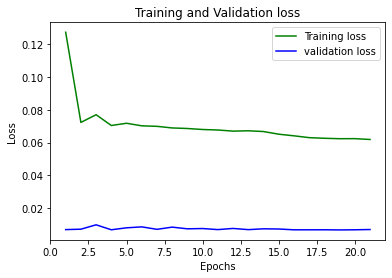

In [27]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = list([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
trainX[len(trainX)-1:].shape

(1, 48, 3)

In [30]:
i=0
total_rmse=0
disy=""

for col in train.resource_id.unique():
  test_col=col
  #print('column value---------',col,float(format( test_col,".5f")))
  lenT=len(train[train['resource_id'] ==test_col])
  #print("------------------------length ",lenT)

  #df_filtered = dataframe[dataframe['resource_id'] ==test_col]
  train_filtered = train[train['resource_id'] ==test_col]
  #predictList = train_filtered[len(train_filtered)-look_back:]
  #print("================",predictList)
  
  

  testX, testY = create_dataset(test, look_back,out_num)
  #testX.shape
  #print("------------------------1")
 
  forecast= test.copy()
  forecast = forecast[forecast['resource_id'] ==test_col] 
  #print("------------------------1.5 ",testX)
  #print(len(forecast))
  forecast['CPU usage [%]'][:]=np.nan
  try:
    i=i+1
    reshaped_test=np.reshape(trainX[len(trainX)-1:],(1,look_back,3))
    #print("------------------------2")
    #print(reshaped_test)
    #print(test_col,' cluster-id ')
    #print('reshaped_test',reshaped_test)
    futureStepPredict = saved_model.predict(reshaped_test)
    #print("------------------------3")
    #print("------------------------3",futureStepPredict)
    #print(testX[0],'predicton goes here',futureStepPredict[0])
    #print("------------------------4",futureStepPredict[0])
    forecast['CPU usage [%]'].iloc[0:out_num]= futureStepPredict[0]
    #print("------------------------5")
    #print("------------------------4",forecast)
    test_mape = test[test['resource_id'] ==test_col]
    #MAPE = (np.mean(np.abs((test_mape[0:out_num] - forecast[0:out_num]) / test_mape[0:out_num])) * 100)
    #print("------------------------5",MAPE)
    # # plot baseline and predictions
    # dft = dataframe.copy()
    # dft = dft[dft['resource_id'] ==test_col] 
    # dft['CPU usage [%]']=scaler.inverse_transform(dft.values)
    # dft = dft[['CPU usage [%]']]

    # fcst = forecast.copy()
    # fcst['CPU usage [%]']=scaler.inverse_transform(fcst.values)
    # fcst = fcst[['CPU usage [%]']]


    plt.figure(figsize=(60, 6))
    plt.yticks(np.arange(1, 100, step=1))
    plt.plot(test_mape['CPU usage [%]'][0:192],linewidth=5) #[lenT+1:lenT+out_num+1]
    plt.plot(forecast['CPU usage [%]'][0:192],color='red')
    plt.show()
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    rmse=sqrt(mean_squared_error(test_mape[0:out_num],forecast[0:out_num]))
    mape = mean_absolute_error(test_mape[0:out_num],forecast[0:out_num])*100

    #print("------------------------6",rmse)

    # if int(MAPE)>100:
    #   disy=disy+","+col

    
    print("------------------------7",i,'cluster-id is :',test_col,' and rmse is :',rmse,'mape',mape)
    
    total_rmse = total_rmse+ rmse
    
  except Exception as ER:
    print(ER,'error',test_col,i)

average_rmse = (total_rmse)/i
print("------------------------8",i,'average rmse is :',average_rmse)


Output hidden; open in https://colab.research.google.com to view.